# Basic Statistics from Movie movies

**Metadata**

| **#** | **Column**               | **Description**                                                                                    |
|-------|--------------------------|----------------------------------------------------------------------------------------------------|
| 1     | **title**                | The official title of the movie.                                                                   |
| 2     | **release_year**         | The year when the movie was officially released.                                                   |
| 3     | **genres**               | Categories of genres the movie belongs to (can have multiple values, separated by commas).         |
| 4     | **director**             | Director(s) of the movie.                                                                          |
| 5     | **runtime**              | Duration of the movie in minutes.                                                                  |
| 6     | **language**             | The language in which the movie was originally produced.                                           |
| 7     | **original_title**       | The title of the movie in its original language.                                                   |
| 8     | **popularity**           | TMDB's score based on votes, views, searches, social engagement, and others.                       |
| 9     | **events**               | Describes events or triggers within the movie (e.g., violence, strong language).                   |
| 10    | **imdb_rating**          | Average rating of the movie on IMDb, on a scale from 0 to 10.                                      |
| 11    | **imdb_votes**           | Number of votes that contributed to the IMDb rating.                                               |
| 12    | **tmdb_rating**          | Rating of the movie on TMDB, on a scale from 0 to 10.                                              |
| 13    | **tmdb_votes**           | Number of votes that contributed to the TMDB rating.                                               |
| 14    | **budget**               | Financial budget allocated for the movie production.                                               |
| 15    | **revenue**              | Box office earnings of the movie.                                                                  |
| 16    | **profit**               | Profit of the movie, calculated as `revenue - budget`.                                             |


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [23]:
import sys
sys.path.append('../utils')
import functions

In [49]:
movies = pd.read_csv('../data/clean/movie_df.csv')
display(movies)

,title,release_year,genres,director,runtime,language,original_title,popularity,events,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,budget,revenue,profit
0,Bad Boys for Life,2020,"thriller, action, crime","Bilall Fallah, Adil El Arbi",124,English,Bad Boys for Life,67.7,"flashing lights or images, shaving or cutting,...",6.5,186716,7.1,8251,90000000,426505244,336505244
1,Avatar: The Way of Water,2022,"science fiction, adventure, action",James Cameron,192,English,Avatar: The Way of Water,158.5,"kids dying, jump scares, people being burned a...",7.5,518001,7.6,11946,460000000,2320250281,1860250281
2,Pet Sematary,2019,"horror, thriller","Dennis Widmyer, Kevin Kölsch",100,English,Pet Sematary,26.1,"dogs dying, kids dying, jump scares, people be...",5.7,100618,5.7,3186,21000000,113118226,92118226
3,How to Train Your Dragon: The Hidden World,2019,"animation, family, adventure",Dean DeBlois,104,English,How to Train Your Dragon: The Hidden World,207.5,"needles or syringes are used, dragons dying, f...",7.4,158269,7.8,6381,129000000,524580592,395580592
4,Star Wars: The Rise of Skywalker,2019,"adventure, action, science fiction",J.J. Abrams,142,English,Star Wars: The Rise of Skywalker,63.2,"jump scares, people being burned alive, flashi...",6.4,507321,6.3,9886,416000000,1074144248,658144248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,Longlegs,2024,"horror, thriller, crime",Osgood Perkins,101,English,Longlegs,153.9,"kids dying, jump scares, flashing lights or im...",6.7,141019,6.6,1475,10000000,126388179,116388179
709,Piece by Piece,2024,"animation, music, documentary",Morgan Neville,94,English,Piece by Piece,34.0,"parents dying, black guy dies first, babies/un...",6.9,3210,7.8,59,16000000,10291872,-5708128
710,Moana 2,2024,"animation, adventure, family, comedy","David G. Derrick Jr., Dana Ledoux Miller, Jaso...",100,English,Moana 2,4485.0,"flashing lights or images, ghosts, bugs, restr...",7.1,30852,6.8,424,150000000,600055655,450055655
711,Sound of Hope: The Story of Possum Trot,2024,drama,Joshua Weigel,130,English,Sound of Hope: The Story of Possum Trot,58.5,"hate speech, child abuse, minority misrepresen...",7.1,1782,6.7,23,8500000,11721425,3221425


In [25]:
print('Basic statistics for numerical columns\n')
movies.describe()

Basic statistics for numerical columns



,release_year,runtime,popularity,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,budget,revenue,profit
count,713.000000,713.000000,713.000000,713.000000,7.130000e+02,713.000000,713.000000,7.130000e+02,7.130000e+02,7.130000e+02
mean,2021.472651,113.497896,96.313745,6.406452,1.059420e+05,6.805891,2293.900421,4.879062e+07,1.255648e+08,7.677414e+07
std,1.790156,21.290798,516.792654,0.965144,1.569708e+05,0.713804,2981.086217,6.634017e+07,2.672777e+08,2.271185e+08
min,2019.000000,57.000000,3.200000,2.200000,1.290000e+02,4.100000,10.000000,8.400000e+01,6.180000e+02,-1.995460e+08
25%,2020.000000,99.000000,19.200000,5.900000,1.759700e+04,6.400000,424.000000,8.000000e+06,4.656348e+06,-5.951429e+06
50%,2022.000000,109.000000,34.000000,6.500000,5.288600e+04,6.800000,1189.000000,2.000000e+07,2.911632e+07,5.163406e+06
75%,2023.000000,125.000000,70.000000,7.000000,1.281400e+05,7.300000,2948.000000,6.000000e+07,1.219775e+08,5.896168e+07
max,2024.000000,209.000000,12656.300000,8.600000,1.565944e+06,8.700000,25781.000000,4.600000e+08,2.799439e+09,2.443439e+09


### Univariate Analysis
- Visualize the Distribution of Numerical Columns
- Check for outliers 

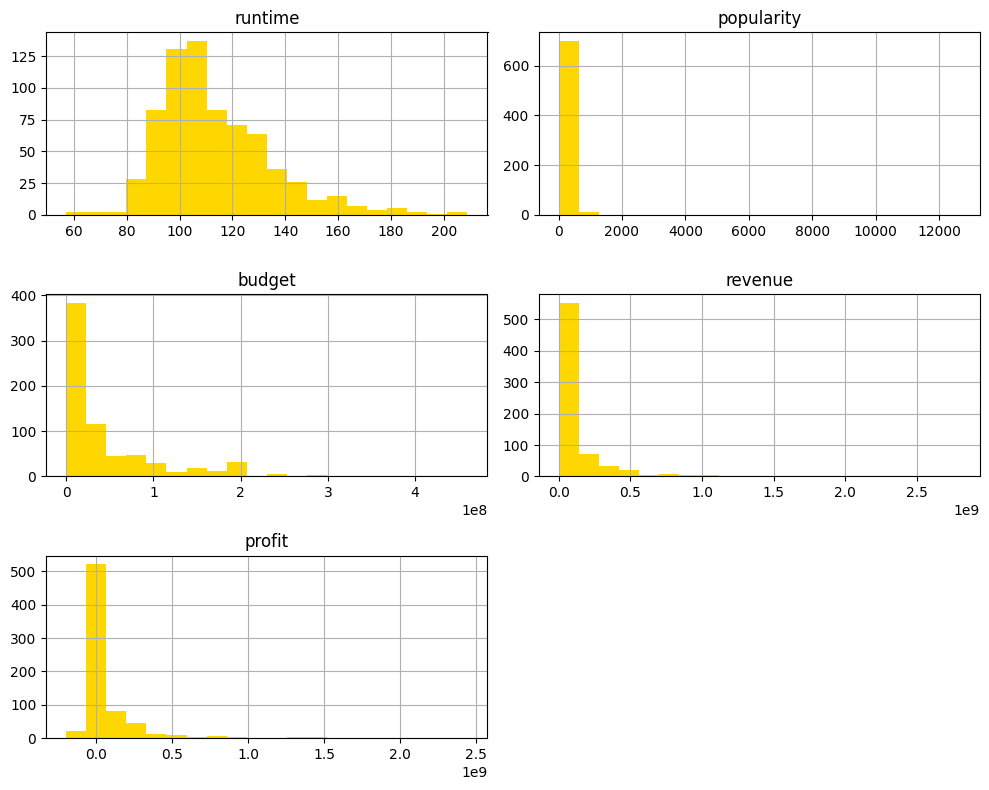

In [48]:
movies[['runtime', 'popularity', 'budget', 'revenue', 'profit']].hist(bins=20, figsize=(10, 8), color='gold')
plt.tight_layout()
plt.show()

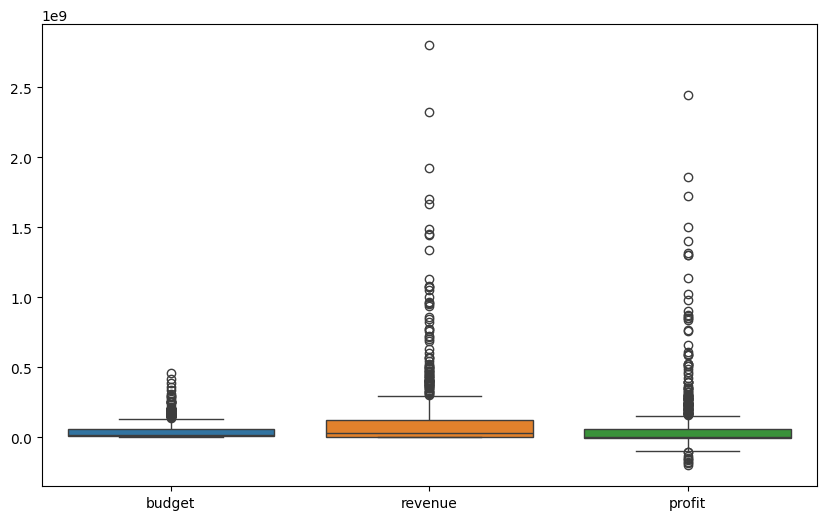

In [27]:
# detect outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies[['budget', 'revenue', 'profit']])
plt.show()

### Bivariate Analysis
Correlation Between Numerical Variables

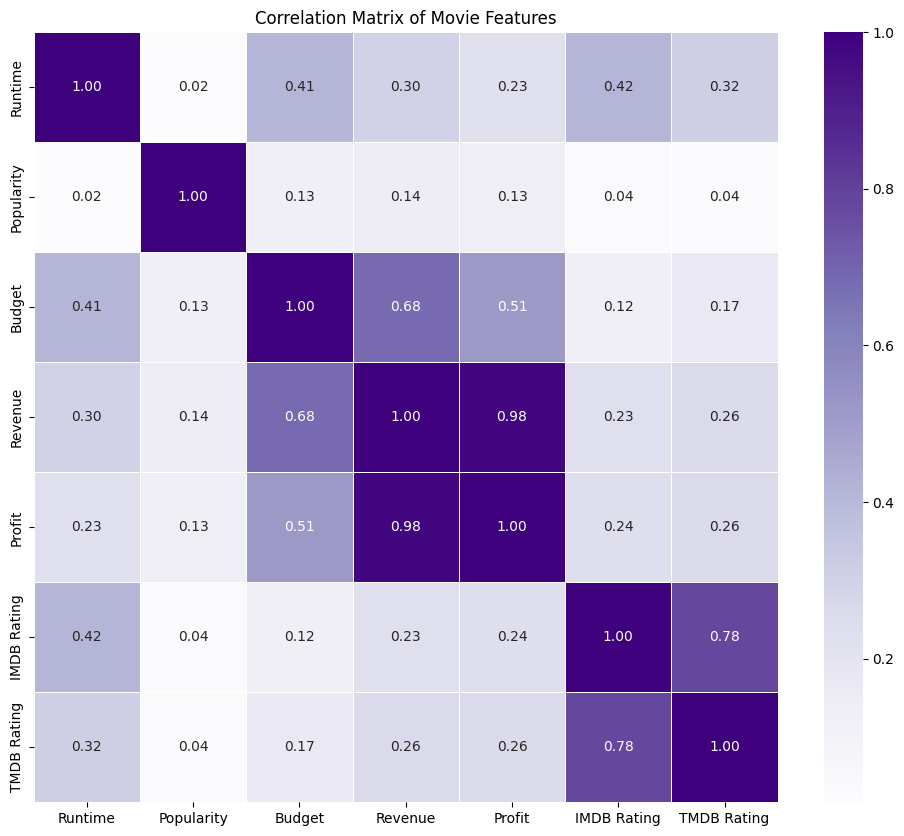

In [28]:
# correlation matrix
correlation_matrix = movies[['runtime', 'popularity', 'budget', 'revenue', 'profit', 'imdb_rating', 'tmdb_rating']].corr()

# Create the heatmap with updated labels
plt.figure(figsize=(12, 10))

# Customizing axis labels for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', fmt='.2f', linewidths=0.5, 
            xticklabels=['Runtime', 'Popularity', 'Budget', 'Revenue', 'Profit', 'IMDB Rating', 'TMDB Rating'],
            yticklabels=['Runtime', 'Popularity', 'Budget', 'Revenue', 'Profit', 'IMDB Rating', 'TMDB Rating'])

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.title('Correlation Matrix of Movie Features', fontsize=12)
plt.show()

### Categorical Data Analysis
- Most common genres
- Most frequent languages and directors

In [29]:
movies['genres'] = movies['genres'].str.split(',')
genres_flat = [genre.strip() for sublist in movies['genres'] for genre in sublist]
genre_counts = pd.Series(genres_flat).value_counts()

print('Most common genres:\n')
print(genre_counts.head(10))

Most common genres:

drama              284
action             211
comedy             206
thriller           205
horror             161
adventure          158
science fiction    104
fantasy             96
crime               93
family              79
Name: count, dtype: int64


In [30]:
print('Most frequent languages:\n')
print(movies['language'].value_counts().head(10))

print('\nMost frequent directiors:\n')
print(movies['director'].value_counts().head(10))

Most frequent languages:

language
English     614
French       30
Spanish      11
Korean        9
Hindi         7
Danish        5
Japanese      4
Chinese       4
Russian       3
Swedish       3
Name: count, dtype: int64

Most frequent directiors:

director
Guy Ritchie           5
Castille Landon       4
M. Night Shyamalan    4
Ti West               3
David Gordon Green    3
Ric Roman Waugh       3
Ridley Scott          3
Taika Waititi         3
Kenneth Branagh       3
Rob Savage            3
Name: count, dtype: int64


### Time-Based Analysis
- Release year trends
- Revenue and profit trends over time 

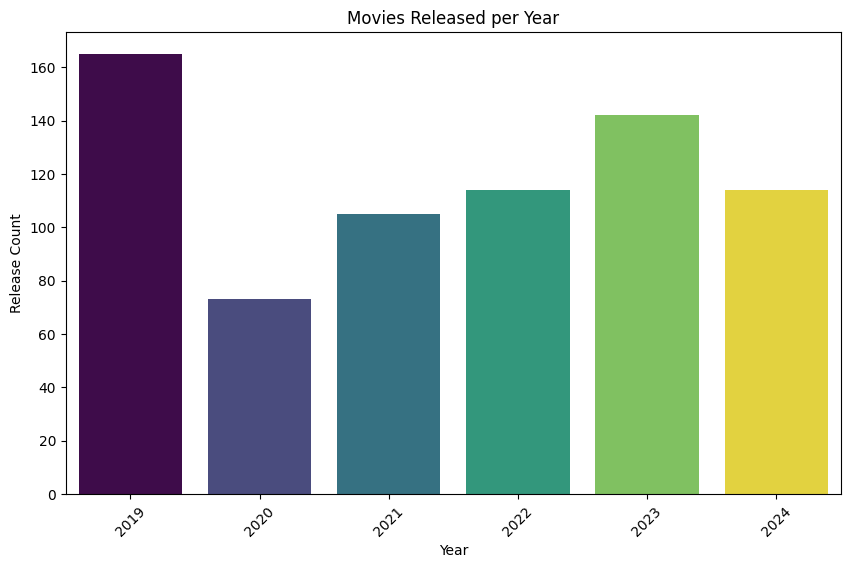

In [31]:
# distribution of movies over years
plt.figure(figsize=(10, 6))
sns.countplot(x='release_year', data=movies, hue='release_year', palette='viridis')
plt.xticks(rotation=45)
plt.title('Movies Released per Year')
plt.ylabel('Release Count')
plt.xlabel('Year')
plt.legend().set_visible(False) # hide legend

plt.show()

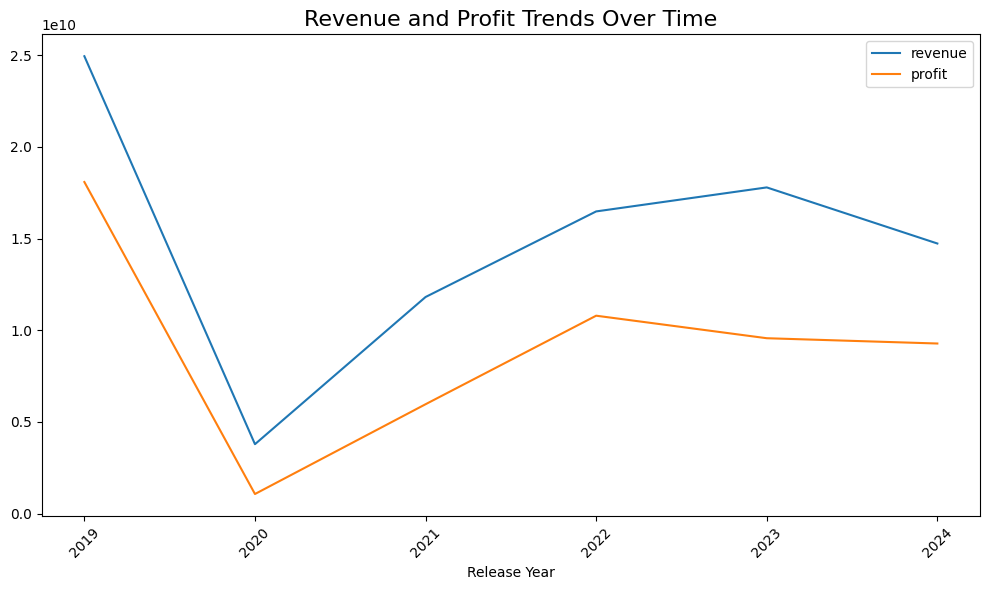

In [32]:
# revenue and profit trends over time
movies.groupby('release_year')[['revenue', 'profit']].sum().plot(kind='line', figsize=(10, 6))
plt.title('Revenue and Profit Trends Over Time', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Release Year')

plt.tight_layout()
plt.show()

### Multicollinearity
- For predictive modeling, check multicollinearity between numerical variables
- VIF (Variance Inflation Factor) for multicollinearity

In [33]:
# constant to the features after removing one of the highly correlated variables (e.g., 'profit')
X = add_constant(movies[['runtime', 'popularity', 'budget', 'imdb_rating', 'tmdb_rating']])

# VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


       feature         VIF
0        const  107.813268
1      runtime    1.453943
2   popularity    1.021241
3       budget    1.259262
4  imdb_rating    2.861186
5  tmdb_rating    2.623066


## VIF Interpretation:

- **`const (107.81)`**: This is the constant term (intercept) in the regression model. High VIF values for the constant are typically not concerning, as this does not represent a feature.
- **`runtime (1.45)`**: A VIF of 1.45 indicates a low degree of multicollinearity. It's a safe value.
- **`popularity (1.02)`**: A VIF close to 1 means there's minimal collinearity with other variables, which is ideal.
- **`budget (1.26)`**: A VIF of 1.26 indicates mild collinearity but is still acceptable and generally not a problem for regression.
- **`imdb_rating (2.86)`**: A VIF value of 2.86 is higher than 1, but still within a reasonable range. Generally, a VIF under 5 is considered acceptable.
- **`tmdb_rating (2.62)`**: Similar to `imdb_rating`, this VIF value is acceptable.

## Conclusion:

The VIFs for all the variables are well below the threshold of **5** (a common rule of thumb), indicating no severe multicollinearity.

You can confidently proceed with building regression models or other analysis techniques without worrying much about multicollinearity for these features.

If you plan on building models (e.g., linear regression), these results suggest that your independent variables are not highly collinear and will not cause issues like instability in the model coefficients.

## Event Analysis

In [34]:
# Step 1: Explode the 'events' column into individual events
events_exploded = movies['events'].str.split(',').explode().str.strip()

# Create a new DataFrame with individual events for each movie
events_df = pd.DataFrame({
    'event': events_exploded,
    'popularity': movies.loc[events_exploded.index, 'popularity'],
    'runtime': movies.loc[events_exploded.index, 'runtime'],
    'budget': movies.loc[events_exploded.index, 'budget'],
    'revenue': movies.loc[events_exploded.index, 'revenue'],
    'profit': movies.loc[events_exploded.index, 'profit'],
    'imdb_rating': movies.loc[events_exploded.index, 'imdb_rating'],
    'tmdb_rating': movies.loc[events_exploded.index, 'tmdb_rating']
})

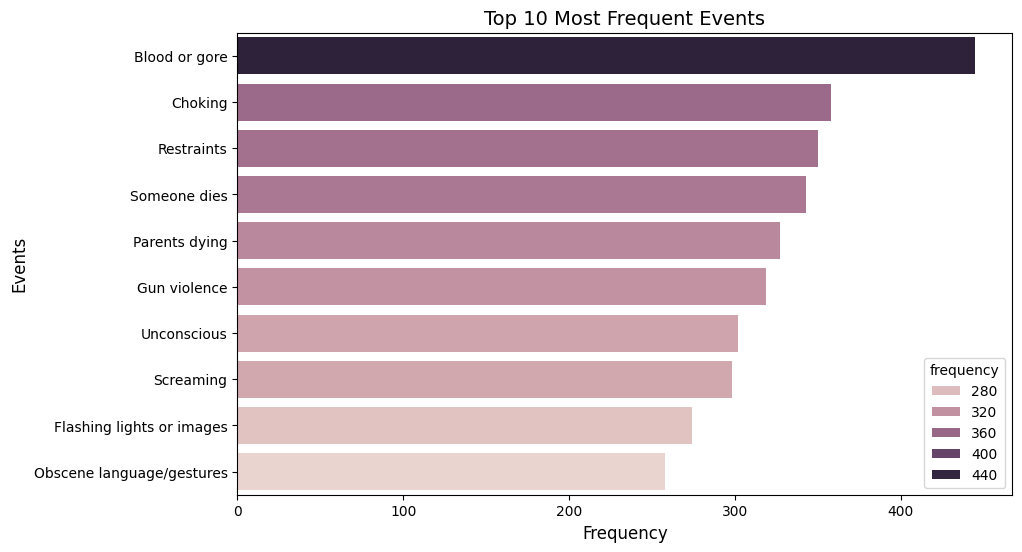

In [35]:
# Step 2: Frequency of Events
event_frequency = events_df['event'].value_counts().reset_index()
event_frequency.columns = ['event', 'frequency']

event_frequency['event'] = event_frequency['event'].str.capitalize()
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='event', data=event_frequency.head(10), hue='frequency')
plt.title('Top 10 Most Frequent Events', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.show()

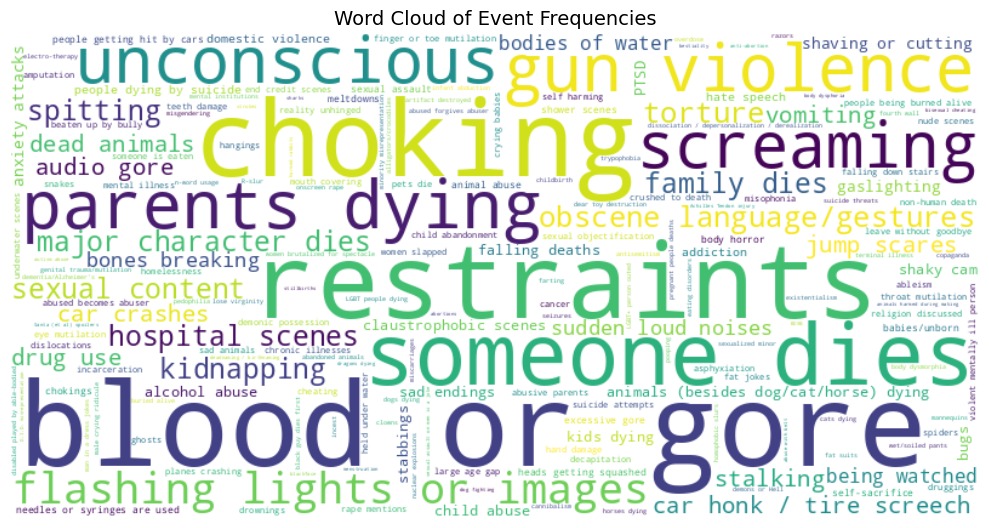

In [36]:


# Step 1: Prepare data
# Exploding the 'genres' and 'events' columns
exploded_genres = movies['genres'].astype(str).str.split(',').explode().str.strip().reset_index(drop=True)
exploded_events = movies['events'].astype(str).str.split(',').explode().str.strip().reset_index(drop=True)

# Step 2: Create a DataFrame combining exploded genres and events
# We will create a DataFrame without worrying about the exact lengths matching
# Filling the shorter column with NaN values so that they can still be joined
max_len = max(len(exploded_genres), len(exploded_events))

# Adjust lengths to match by padding the shorter list with NaN values
exploded_genres = exploded_genres.reindex(range(max_len))
exploded_events = exploded_events.reindex(range(max_len))

# Create the DataFrame
events_per_genre = pd.DataFrame({'genre': exploded_genres, 'event': exploded_events})

# Step 3: Calculate the frequency of each event
event_frequency = events_per_genre.groupby('event').size().reset_index(name='frequency')

# Step 4: Convert the event frequencies to a dictionary for the word cloud
event_frequency_dict = dict(zip(event_frequency['event'], event_frequency['frequency']))

# Step 5: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(event_frequency_dict)

# Step 6: Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Event Frequencies', fontsize=14)
plt.tight_layout()
plt.show()